In [330]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [129]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import chromATAC as ca
from chromATAC.integrated import IntData
from functools import reduce
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
from tqdm import tqdm
import warnings
import seaborn as sns
import pandas as pd
from scipy import stats
import matplotlib.patches as mpatches


warnings.simplefilter("ignore", category=pd.errors.ParserWarning)

In [130]:
def get_gaps(df):
    # Ensure the DataFrame is sorted
    df_sorted = df.sort_values(by=['chr', 'start'])

    # Prepare the list to store gap regions
    gaps = []

    # Iterate over the DataFrame
    for chrom, group in df_sorted.groupby('chr'):
        prev_end = None
        for _, row in group.iterrows():
            if prev_end is not None and prev_end < row['start']:
                # Found a gap
                gaps.append([chrom, prev_end, row['start']])
            prev_end = row['end']

    # Create a DataFrame for gaps
    gaps_df = pd.DataFrame(gaps, columns=['chr', 'start', 'end'])
    return gaps_df

In [131]:
parent_dir = '/Users/mossishahi/Code/lupien/IntData'
os.chdir(parent_dir)

In [132]:
tes_dir = './data/V2-TEs/TEs/'
cotes_dir = './data/V2-TEs/CoTEs/'

In [133]:
TEs = np.array([i.split('.')[0] for i in os.listdir(tes_dir) if i.endswith('.bed')])
COTEs = np.array([i.split('.')[0] for i in os.listdir(cotes_dir) if i.endswith('.bed')])

In [82]:
te_meta = pd.read_csv('./analysis/data/repeat_metadata.onlyTEs_full.tsv', sep='\t')
te_df = te_meta.iloc[np.concatenate([np.where(te_meta['repname_numbered'].apply(lambda x: i.split('_')[1]==x.split('_')[0]))[0] for i in TEs]), :].loc[:, ['repname', 'Superfamily', 'repname_numbered']].copy()
te_df.index = range(1, len(te_df)+1)
te_df['COTE'] = te_df['repname_numbered'].apply(lambda x: x.split('_')[0] in np.array([i.split('_')[0] for i in np.intersect1d([i.split('te_')[-1] for i in TEs], [i.split('cote_')[-1] for i in COTEs])]))
te_df.loc[971] = ['ERV3-16A3_I-int', 'ERVL', '369_ERV3-16A3_I-int', True]

In [83]:
te_n_elements = pd.read_csv(tes_dir+'/n_elements_per_TE.tsv', sep='\t', header=None, names = ['name', 'n_elements'])
cote_n_elments = pd.read_csv(cotes_dir+'/cote_n_clusters_per_TE.tsv', sep='\t', header=None, names = ['name', 'n_clusters'])

In [84]:
te_n_elements['name'] = te_n_elements['name'].apply(lambda x: x.split('_Merged.bed')[0])
cote_n_elments['name'] = cote_n_elments['name'].apply(lambda x: x.split('_Merged.bed')[0])
te_df = te_df.merge(te_n_elements, how='left', left_on='repname_numbered', right_on='name').merge(cote_n_elments, how='left', left_on='repname_numbered', right_on='name').drop(['name_x', 'name_y'], axis=1).fillna(0)
te_df.set_index('repname_numbered', inplace=True)

In [85]:
for t in TEs:
    df = pd.read_csv(str(os.path.join(tes_dir,t))+ '.bed', sep='\t', names=['chr', 'start', 'end', 'value'])
    df['length']=df['end']-df['start']
    te_df.loc[pd.Series(te_df.index).apply(lambda x: x in t.split('_Merged')[0]).values,'mean_length']=df['length'].mean()

In [86]:
cote_df = te_df[te_df.COTE].copy()

In [88]:
for t in COTEs:
    df = pd.read_csv(str(os.path.join(cotes_dir,t))+ '.bed', sep='\t', names=['chr', 'start', 'end', 'value'])
    df['length'] = df['end']-df['start']
    cote_df.loc[pd.Series(cote_df.index).apply(lambda x: x in t.split('_Merged')[0]).values,'mean_length']=df['length'].mean()

In [89]:
for t in TEs:
    df = pd.read_csv(str(os.path.join(tes_dir,t))+ '.bed', sep='\t', names=['chr', 'start', 'end', 'value'])
    df = get_gaps(df)
    df['length']=df['end']-df['start']
    te_df.loc[pd.Series(te_df.index).apply(lambda x: x in t.split('_Merged')[0]).values,'mean_dist_length']=df['length'].mean()

In [90]:
for t in COTEs:
    df = pd.read_csv(str(os.path.join(cotes_dir,t))+ '.bed', sep='\t', names=['chr', 'start', 'end', 'value'])
    df = get_gaps(df)
    df['length']=df['end']-df['start']
    cote_df.loc[pd.Series(cote_df.index).apply(lambda x: x in t.split('_Merged')[0]).values,'mean_CoTEs_dist_length']=df['length'].mean()

In [91]:
te_df

,repname,Superfamily,COTE,n_elements,n_clusters,mean_length,mean_dist_length
repname_numbered,,,,,,,
764_LTR36,LTR36,ERV1,False,504,0.0,379.301587,5.718405e+06
691_LTR16A1,LTR16A1,ERV3,True,2726,39.0,267.259354,1.057406e+06
1372_Tigger12,Tigger12,Transposons,False,970,0.0,195.914433,2.931965e+06
560_L1M,L1M,LINE1,False,749,0.0,103.778371,3.866368e+06
1514_UCON27,UCON27,SINE2,False,100,0.0,214.470000,2.053928e+07
...,...,...,...,...,...,...,...
786_LTR43,LTR43,ERV1,False,467,0.0,360.927195,5.632299e+06
838_LTR75B,LTR75B,ERV3,False,202,0.0,299.633663,1.090485e+07
1114_MER90a,MER90a,ERV1,True,1273,27.0,323.063629,2.266307e+06


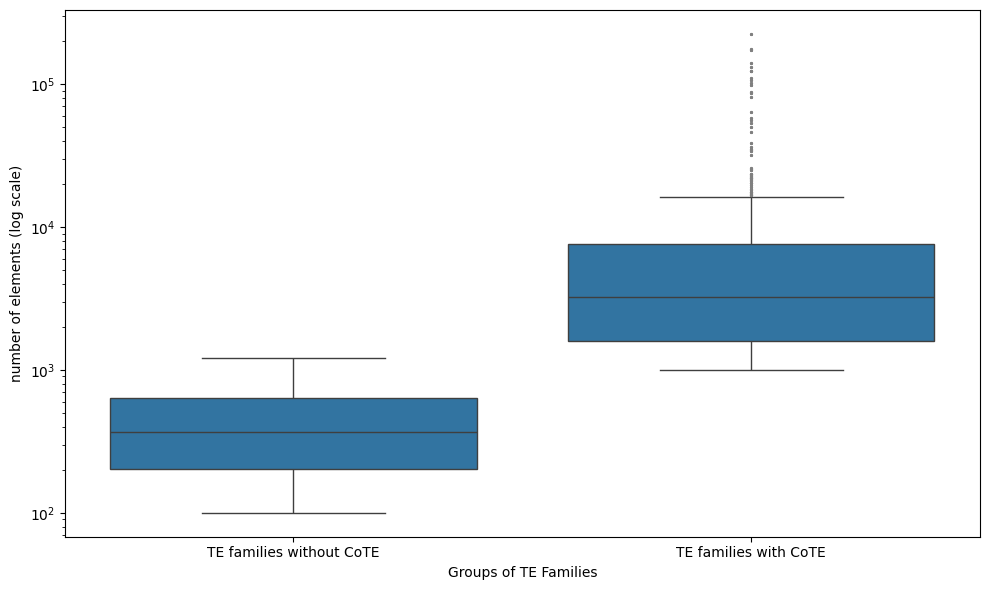

In [95]:
fig=plt.figure(figsize=(10, 6))
sns.boxplot(x=te_df['COTE'], y=te_df['n_elements'], showfliers=True, fliersize=2, flierprops=dict(marker='*', color='grey', markeredgecolor='grey'))  # Custom flier color)
plt.yscale('log')
plt.xlabel('Groups of TE Families')
plt.xticks(ticks=[0, 1], labels=['TE families without CoTE', 'TE families with CoTE'])
plt.ylabel('number of elements (log scale)')
plt.tight_layout()
plt.show()
fig.savefig('n_elements.png', dpi=600)

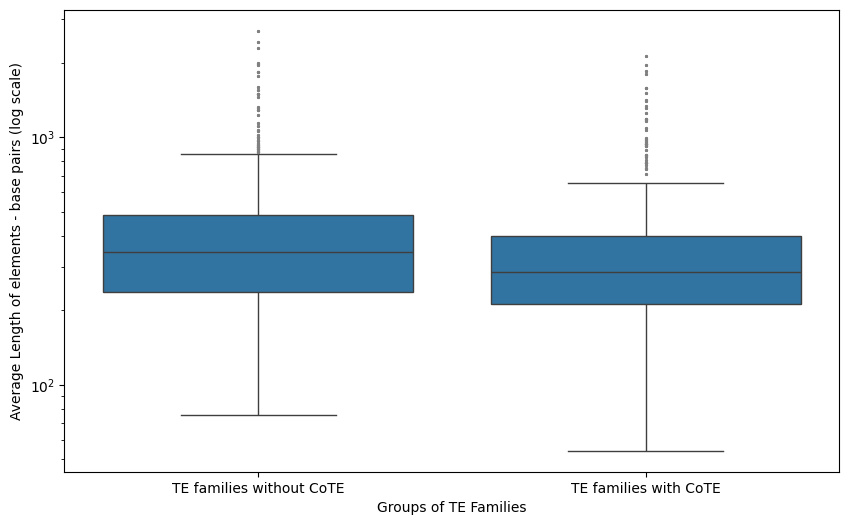

In [96]:
fig=plt.figure(figsize=(10, 6))
sns.boxplot(x=te_df['COTE'], y=te_df['mean_length'], showfliers=True, fliersize=2, flierprops=dict(marker='*', color='grey', markeredgecolor='grey'))  # Custom flier color)
plt.yscale('log')
plt.xlabel('Groups of TE Families')
plt.xticks(ticks=[0, 1], labels=['TE families without CoTE', 'TE families with CoTE'])
plt.ylabel('Average Length of elements - base pairs (log scale)')
plt.show()
fig.savefig('len_elements.png', dpi=600)

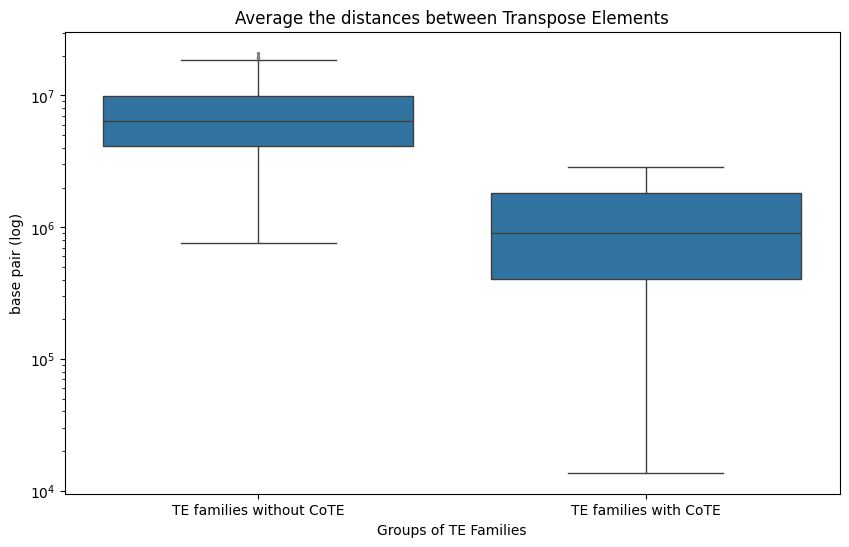

In [97]:
fig=plt.figure(figsize=(10, 6))
sns.boxplot(x=te_df['COTE'], y=te_df['mean_dist_length'], showfliers=True, fliersize=2, flierprops=dict(marker='*', color='grey', markeredgecolor='grey'))  # Custom flier color)
plt.title('Average the distances between Transpose Elements')
plt.yscale('log')
plt.xlabel('Groups of TE Families')
plt.xticks(ticks=[0, 1], labels=['TE families without CoTE', 'TE families with CoTE'])
plt.ylabel('base pair (log)')
plt.show()
fig.savefig('mean_dist_elements.png', dpi=600)

In [117]:
ctes = []
for f in COTEs:
    df = pd.read_csv(cotes_dir+'/'+f+'.bed', sep='\t', names=['chr', 'start', 'end'], index_col=False)
    cdf = df.groupby('chr').count()
    cdf.rename(columns={'start': f.split('_Merged')[0]}, inplace=True)
    cdf = cdf.T.loc[:, [i for i in cdf.T.columns if i in ca.info.CHROMOSOMES['names']]].iloc[0,:].T
    ctes.append(cdf)

_ctes = pd.concat(ctes, axis=1).T.fillna(0)
__ctes = _ctes.div(_ctes.sum(1), axis=0).fillna(0)
_ctes = _ctes.join(te_df)
df_ct = _ctes.groupby(['Superfamily']).sum()
df_ct = df_ct.sort_index(axis=0).sort_index(axis=1)
df_ct = df_ct.loc[:, [i for i in df_ct.columns if 'chr' in i]]
ct_row_sums = df_ct.sum(axis=1)
df_ct_percentage = df_ct.div(ct_row_sums, axis=0) * 100
df_ct_percentage.fillna(0, inplace=True)

In [134]:
tes = []
for f in TEs:
    df = pd.read_csv(tes_dir+'/'+f+'.bed', sep='\t', names=['chr', 'start', 'end'], index_col=False)
    cdf = df.groupby('chr').count()
    cdf.rename(columns={'start': f.split('_Merged')[0]}, inplace=True)
    cdf = cdf.T.loc[:, [i for i in cdf.T.columns if i in ca.info.CHROMOSOMES['names']]].iloc[0,:].T
    tes.append(cdf)

_tes = pd.concat(tes, axis=1).T.fillna(0)
__tes = _tes.div(_tes.sum(1), axis=0).fillna(0)
_tes = _tes.join(te_df)
df_t = _tes.groupby(['Superfamily']).sum().sort_index(axis=0).sort_index(axis=1)
df_t = df_t.sort_index(axis=0).sort_index(axis=1)
df_t = df_t.loc[:, [i for i in df_t.columns if 'chr' in i]]
te_row_sums = df_t.sum(axis=1)
df_t_percentage = df_t.div(te_row_sums, axis=0) * 100
df_t_percentage.fillna(0, inplace=True)

In [119]:
def plot_te_family_distribution(df1, df2, te_family_name):
    """
    Plots the distribution of a specified TE family across all chromosomes
    in two given dataframes.

    :param df1: First dataframe.
    :param df2: Second dataframe.
    :param te_family_name: Part of the name of the TE family to search for.
    """

    # Find the row index in each dataframe that contains the specified TE family name
    index_df1 = [i for i in df1.index if te_family_name in str(i)]
    index_df2 = [i for i in df2.index if te_family_name in str(i)]

    # Check if the TE family is found in both dataframes
    if not index_df1 or not index_df2:
        print("TE family not found in one or both dataframes.")
        return

    # Extract the rows for the specified TE family
    te_family_df1 = df1.loc[index_df1]
    te_family_df2 = df2.loc[index_df2]

    bar_width = 0.35

    # Plotting the distributions
    fig = plt.figure(figsize=(18, 8 * len(index_df1)))

    for idx, (index_1, index_2) in enumerate(zip(index_df1, index_df2)):
        positions = range(len(te_family_df1.columns))
        legend_text2 = 'CoTEs'
        legend_text1 = 'TEs'
        plt.subplot(len(index_df1), 1, idx + 1)
        plt.bar([p - bar_width/2 for p in positions], te_family_df1.loc[index_1].values, bar_width, label=legend_text1)
        plt.bar([p + bar_width/2 for p in positions], te_family_df2.loc[index_2].values, bar_width, label=legend_text2)
        plt.title(f'Distribution of TEs vs CoTEs from Family "{te_family_name.split('_')[-1]}" Across genome', fontsize=22)
        plt.xlabel('Chromosome')
        plt.ylabel('Percentage of Total')
        plt.xticks(positions, te_family_df1.columns, rotation=45)
        plt.legend()

    plt.tight_layout()
    plt.show()
    return fig
# Example usage of the function
# plot_te_family_distribution(tes_df, ctes_df, "542_L1MA1")  # Uncomment to use the function

## Evolutionary Age

In [109]:
kimura = pd.read_csv('./analysis/figures/figure 1/kimura_distance_hg38.tsv', sep='\t')

In [114]:
kimura

,Repeat,Class,Kimura%
0,5S,rRNA,10.68
1,7SK,RNA,20.69
2,7SLRNA,SINE/Alu,13.57
3,ACRO1,Satellite/acromeric,16.50
4,AluJb,SINE/Alu,12.47
...,...,...,...
1329,Zaphod3,DNA/hAT-Tip100,23.37
1330,Zaphod4a,DNA/hAT-Tip100,30.92
1331,Zaphod5a,DNA/hAT-Tip100,29.54
1332,Zaphod5b,DNA/hAT-Tip100,28.94


In [110]:
te_df = te_df.merge(kimura, right_on='Repeat', left_on='repname')

In [111]:
te_df

,repname,Superfamily,COTE,n_elements,n_clusters,mean_length,mean_dist_length,Repeat_x,Class_x,Kimura%_x,Repeat_y,Class_y,Kimura%_y
0,LTR36,ERV1,False,504,0.0,379.301587,5.718405e+06,LTR36,LTR/ERV1,17.83,LTR36,LTR/ERV1,17.83
1,LTR16A1,ERV3,True,2726,39.0,267.259354,1.057406e+06,LTR16A1,LTR/ERVL,30.61,LTR16A1,LTR/ERVL,30.61
2,Tigger12,Transposons,False,970,0.0,195.914433,2.931965e+06,Tigger12,DNA/TcMar-Tigger,32.22,Tigger12,DNA/TcMar-Tigger,32.22
3,L1M,LINE1,False,749,0.0,103.778371,3.866368e+06,L1M,LINE/L1,33.12,L1M,LINE/L1,33.12
4,UCON27,SINE2,False,100,0.0,214.470000,2.053928e+07,UCON27,Unknown,30.48,UCON27,Unknown,30.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,LTR43,ERV1,False,467,0.0,360.927195,5.632299e+06,LTR43,LTR/ERV1,14.24,LTR43,LTR/ERV1,14.24
962,LTR75B,ERV3,False,202,0.0,299.633663,1.090485e+07,LTR75B,LTR/ERVL,26.24,LTR75B,LTR/ERVL,26.24
963,MER90a,ERV1,True,1273,27.0,323.063629,2.266307e+06,MER90a,LTR/ERV1,27.78,MER90a,LTR/ERV1,27.78
964,MER50-int,ERV1,False,515,0.0,799.271845,4.412513e+06,MER50-int,LTR/ERV1,17.54,MER50-int,LTR/ERV1,17.54


/var/folders/dh/z5vdtxqd23qd9l10wsz4vjbw0000gp/T/ipykernel_45783/2029808822.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=te_df['Kimura%_x'], y=te_df['COTE'],orient='h', palette=["orange", "steelblue"], linecolor='grey')


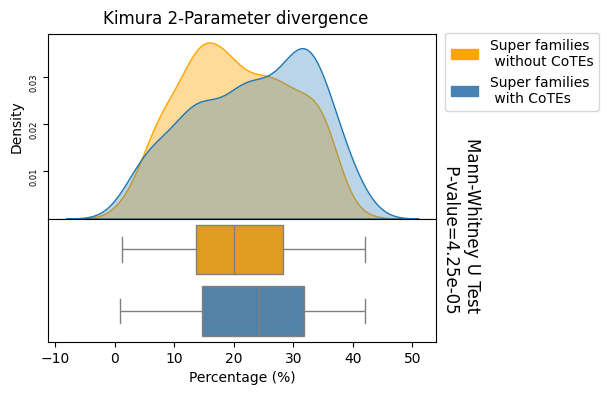

In [116]:
fig, axs = plt.subplots(2, 1, figsize=(5, 4), sharex=True, height_ratios=[3, 2])
sns.kdeplot(te_df[~te_df['COTE']].loc[:,'Kimura%_x'].values, fill=True, alpha=0.4, color='orange', ax=axs[0])
sns.kdeplot(te_df[te_df['COTE']].loc[:,'Kimura%_x'].values, fill=True, alpha=0.3, ax=axs[0])
plt.subplots_adjust(hspace=0)
sns.boxplot(x=te_df['Kimura%_x'], y=te_df['COTE'],orient='h', palette=["orange", "steelblue"], linecolor='grey')
axs[0].set_yticks([0.01, 0.02, 0.03])
axs[1].set_yticklabels([])
orange_patch = mpatches.Patch(color='orange', label='Super families \n without CoTEs')
blue_patch = mpatches.Patch(color='steelblue', label='Super families \n with CoTEs')
fig.legend(handles=[orange_patch, blue_patch], loc='upper right', bbox_to_anchor=(1.24,.9))
axs[0].tick_params(axis='y', labelsize=6, rotation=90)
axs[1].tick_params(axis='y', labelsize=6, length=0)
axs[1].set_ylabel('')
# Create a second y-axis sharing the same x-axis
fig.text(0.99, 0.4, 'Mann-Whitney U Test\n P-value=4.25e-05', fontdict={'fontsize':12},  va='center', ha='right', rotation=270)

plt.suptitle('Kimura 2-Parameter divergence', y=0.94)
plt.xlabel('Percentage (%)')
plt.show()
fig.savefig('/Users/mossishahi/code/lupien/IntData/analysis/figures/figure 1/kimura.png', dpi=600, bbox_inches='tight')

In [89]:
# Assuming 'df' is your DataFrame and 'signal' is the column you want to test
# Replace 'signal' with the name of your signal column

# Perform Shapiro-Wilk test
shapiro_test = stats.shapiro(te_df['Kimura%'])

# shapiro_test will return a tuple (test statistic, p-value)
print("Shapiro-Wilk test statistic:", shapiro_test[0])
print("P-value:", shapiro_test[1])

# Interpretation
if shapiro_test[1] > 0.05:
    print("The data is likely normally distributed.")
else:
    print("The data is likely not normally distributed.")

Shapiro-Wilk test statistic: 0.9744425415992737
P-value: 5.349389767955737e-12
The data is likely not normally distributed.


In [99]:
ca.al.stats.mann_whitney_test(te_df[te_df['COTE']].loc[:,'Kimura%'].values, te_df[~te_df['COTE']].loc[:,'Kimura%'].values)

4.257640830148243e-05

In [259]:
diff.T

chr,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
691_LTR16A1,-0.454229,-5.470785,14.844503,-3.651007,-3.204413,-4.168217,-3.796055,-2.608953,0.033399,-3.498325,...,-1.749163,-3.018331,-1.674730,-1.525865,-1.749163,18.528909,-1.116487,-0.744325,5.157787,-0.297730
1127_MER96B,-11.764706,-1.913346,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.173941,...,-6.925996,3.012334,-0.490196,-3.984820,30.281467,0.000000,0.000000,0.000000,0.000000,0.000000
979_MER3,1.292847,-2.185133,-0.135626,-1.727155,-1.524355,-1.505643,-0.641585,-2.176496,-0.744744,-0.495164,...,0.889567,2.982816,1.769298,-1.390808,3.316364,2.480616,-0.907560,-0.427111,0.225511,0.758099
501_HSMAR2,-0.780142,-7.726764,-2.209780,3.393057,-4.897350,3.784994,-1.201941,3.001120,-2.351624,-0.306084,...,-1.455767,-1.959686,0.421799,3.363195,1.205674,-1.399776,-0.951848,-0.615901,12.777156,-0.559910
532_L1M4a2,4.759457,-4.594984,-5.957031,-5.126953,-0.010280,-1.230983,-0.010280,-4.785156,-1.030530,-0.639905,...,1.796361,-1.416016,1.894017,4.037315,0.678454,0.239001,-1.367188,-0.830078,11.628803,-0.585938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617_L1PA13,0.550605,-1.374430,0.120205,1.035444,-1.374430,-0.909612,-3.512033,-1.610528,-0.251371,-1.711588,...,-0.963613,-2.265262,-1.404463,-1.586122,0.157691,-1.200589,0.802414,-0.509684,13.653320,2.239979
567_L1MC5,-0.919514,-1.959721,-0.666136,-0.459413,-0.027837,1.020981,0.451059,-2.143365,2.091760,0.458530,...,1.011013,0.263798,-1.079605,0.291420,-0.107323,0.914778,-0.631280,-0.225067,0.904142,-0.328321
85_Alu,-2.350240,2.711679,-3.314671,-3.530207,-2.633626,0.294609,3.438126,-3.189685,-1.861776,1.906159,...,2.507875,1.667921,2.337487,0.294864,7.160913,2.893800,0.816998,3.302427,-1.657463,0.567282
1383_Tigger18a,1.388108,0.588108,6.536216,-2.657297,3.593514,-4.480000,-2.417297,0.285405,-0.977297,1.005405,...,0.382703,-3.120000,-1.600000,-2.000000,0.302703,3.068108,-1.120000,1.582703,0.142703,-0.640000


In [260]:
te_df

,repname,Superfamily,repname_numbered
422,LTR36,ERV1,764_LTR36
352,LTR16A1,ERV3,691_LTR16A1
911,Tigger12,Transposons,1372_Tigger12
177,L1M,LINE1,560_L1M
950,UCON27,SINE2,1514_UCON27
...,...,...,...
923,Tigger18a,Transposons,1383_Tigger18a
444,LTR43,ERV1,786_LTR43
498,LTR75B,ERV3,838_LTR75B
770,MER90a,ERV1,1114_MER90a


In [318]:
d = diff.T

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,Superfamily
352,-0.454229,-5.470785,14.844503,-3.651007,-3.204413,-4.168217,-3.796055,-2.608953,0.033399,-3.498325,...,-3.018331,-1.674730,-1.525865,-1.749163,18.528909,-1.116487,-0.744325,5.157787,-0.297730,ERV3
783,-11.764706,-1.913346,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.173941,...,3.012334,-0.490196,-3.984820,30.281467,0.000000,0.000000,0.000000,0.000000,0.000000,Transposons
616,1.292847,-2.185133,-0.135626,-1.727155,-1.524355,-1.505643,-0.641585,-2.176496,-0.744744,-0.495164,...,2.982816,1.769298,-1.390808,3.316364,2.480616,-0.907560,-0.427111,0.225511,0.758099,Transposons
164,-0.780142,-7.726764,-2.209780,3.393057,-4.897350,3.784994,-1.201941,3.001120,-2.351624,-0.306084,...,-1.959686,0.421799,3.363195,1.205674,-1.399776,-0.951848,-0.615901,12.777156,-0.559910,Transposons
194,4.759457,-4.594984,-5.957031,-5.126953,-0.010280,-1.230983,-0.010280,-4.785156,-1.030530,-0.639905,...,-1.416016,1.894017,4.037315,0.678454,0.239001,-1.367188,-0.830078,11.628803,-0.585938,LINE1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,0.550605,-1.374430,0.120205,1.035444,-1.374430,-0.909612,-3.512033,-1.610528,-0.251371,-1.711588,...,-2.265262,-1.404463,-1.586122,0.157691,-1.200589,0.802414,-0.509684,13.653320,2.239979,LINE1
227,-0.919514,-1.959721,-0.666136,-0.459413,-0.027837,1.020981,0.451059,-2.143365,2.091760,0.458530,...,0.263798,-1.079605,0.291420,-0.107323,0.914778,-0.631280,-0.225067,0.904142,-0.328321,LINE1
2,-2.350240,2.711679,-3.314671,-3.530207,-2.633626,0.294609,3.438126,-3.189685,-1.861776,1.906159,...,1.667921,2.337487,0.294864,7.160913,2.893800,0.816998,3.302427,-1.657463,0.567282,SINE1
923,1.388108,0.588108,6.536216,-2.657297,3.593514,-4.480000,-2.417297,0.285405,-0.977297,1.005405,...,-3.120000,-1.600000,-2.000000,0.302703,3.068108,-1.120000,1.582703,0.142703,-0.640000,Transposons


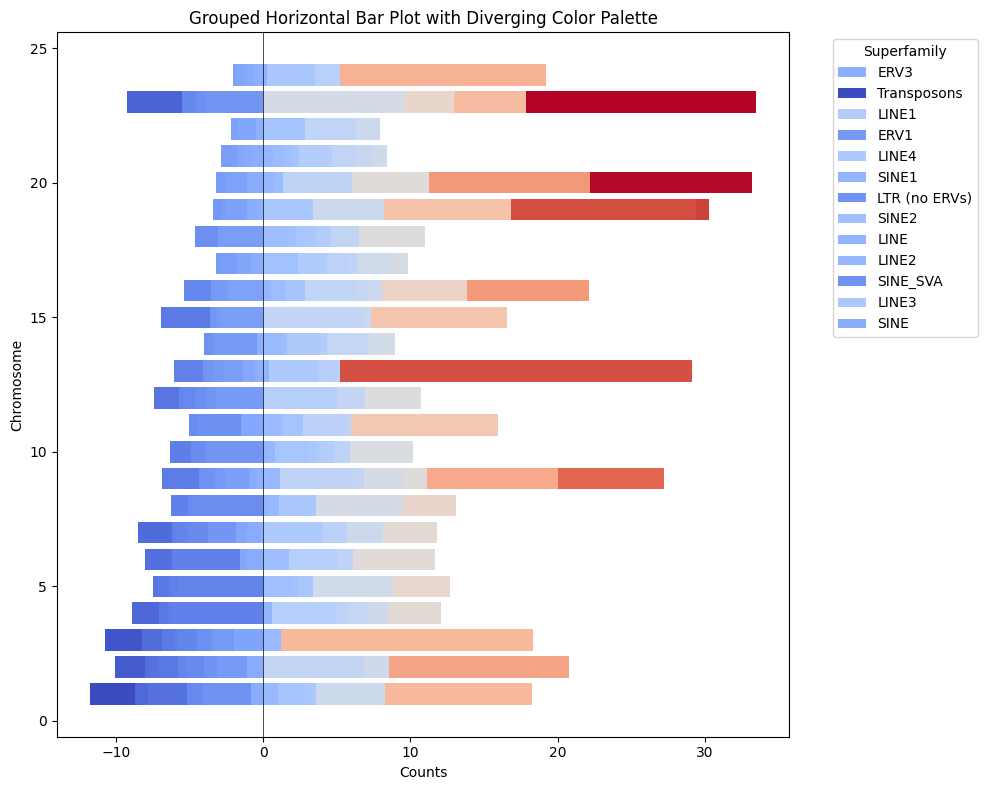

In [323]:
# Reset the index so that Superfamily becomes a column, then melt the DataFrame to long-form
df_reset = d.merge(te_df, right_on='repname_numbered', left_index=True).drop(columns=['repname', 'repname_numbered'])
df_long = df_reset.melt(id_vars='Superfamily', var_name='Chromosome', value_name='Counts')

# Define a function to map the values to colors
def value_to_color(val):
    norm = mcolors.Normalize(vmin=df_long['Counts'].min(), vmax=df_long['Counts'].max())
    cmap = plt.get_cmap('coolwarm')
    return cmap(norm(val))

# Create the bar plot
plt.figure(figsize=(10, 8))
for superfamily in df_long['Superfamily'].unique():
    subset = df_long[df_long['Superfamily'] == superfamily]
    plt.barh(subset['Chromosome'], subset['Counts'], color=subset['Counts'].apply(value_to_color), label=superfamily)

# Set labels and title
plt.xlabel('Counts')
plt.ylabel('Chromosome')
plt.title('Grouped Horizontal Bar Plot with Diverging Color Palette')

# Display the plot
plt.legend(title='Superfamily', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axvline(0, color='black', linewidth=0.5)  # Add zero line
plt.tight_layout()
plt.show()


In [25]:
diff.to_csv('./diff.csv', index=False)

In [327]:
df_long

,Superfamily,Chromosome,Counts
0,ERV3,1,-0.454229
1,Transposons,1,-11.764706
2,Transposons,1,1.292847
3,Transposons,1,-0.780142
4,LINE1,1,4.759457
...,...,...,...
10843,LINE1,24,2.239979
10844,LINE1,24,-0.328321
10845,SINE1,24,0.567282
10846,Transposons,24,-0.640000


In [329]:
# Convert the DataFrame to long-form
df_long_new = df_long.copy()

# Define a function to map the values to colors
def value_to_color(val):
    norm = mcolors.Normalize(vmin=df_long_new['Counts'].min(), vmax=df_long_new['Counts'].max())
    cmap = plt.get_cmap('coolwarm_r')
    return cmap(norm(val))

# Create a 4x6 grid of subplots
fig, axs = plt.subplots(4, 6, figsize=(15, 10), constrained_layout=True)

# Iterate over each chromosome and plot on separate ax
for ax, chromosome in zip(axs.ravel(), ca.info.CHROMOSOMES['names']):
    subset = df_long_new[df_long_new['Chromosome'] == chromosome]
    for category in subset['Superfamily'].unique():
        subsubset = subset[subset['Superfamily'] == category]
        ax.barh(subsubset['Superfamily'], subsubset['Counts'], color=subsubset['Counts'].apply(value_to_color))
    # Set title for each ax and adjust y-axis labels
    if chromosome=='chrY':
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.1f}%'.format(x)))
        ax.tick_params(axis='x', labelsize=6, which='both', pad=1)
    else:
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}%'.format(x)))
        ax.tick_params(axis='x', labelsize=7, which='both', pad=1)
    ax.set_title(chromosome, fontsize=10)
    ax.set_yticks(subset['Superfamily'].unique())
    ax.set_yticklabels(subset['Superfamily'].unique(), fontsize=7)
    ax.grid(False)
    ax.axvline(0, color='grey', linewidth=0.2)  # Add zero line
# Set a global title for the entire figure
# fig.suptitle('Grouped Horizontal Bar Plot with Diverging Color Palette per Chromosome', fontsize=16)
plt.show()
fig.savefig('figure1-B.png')

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

<Figure size 1500x1000 with 24 Axes>

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

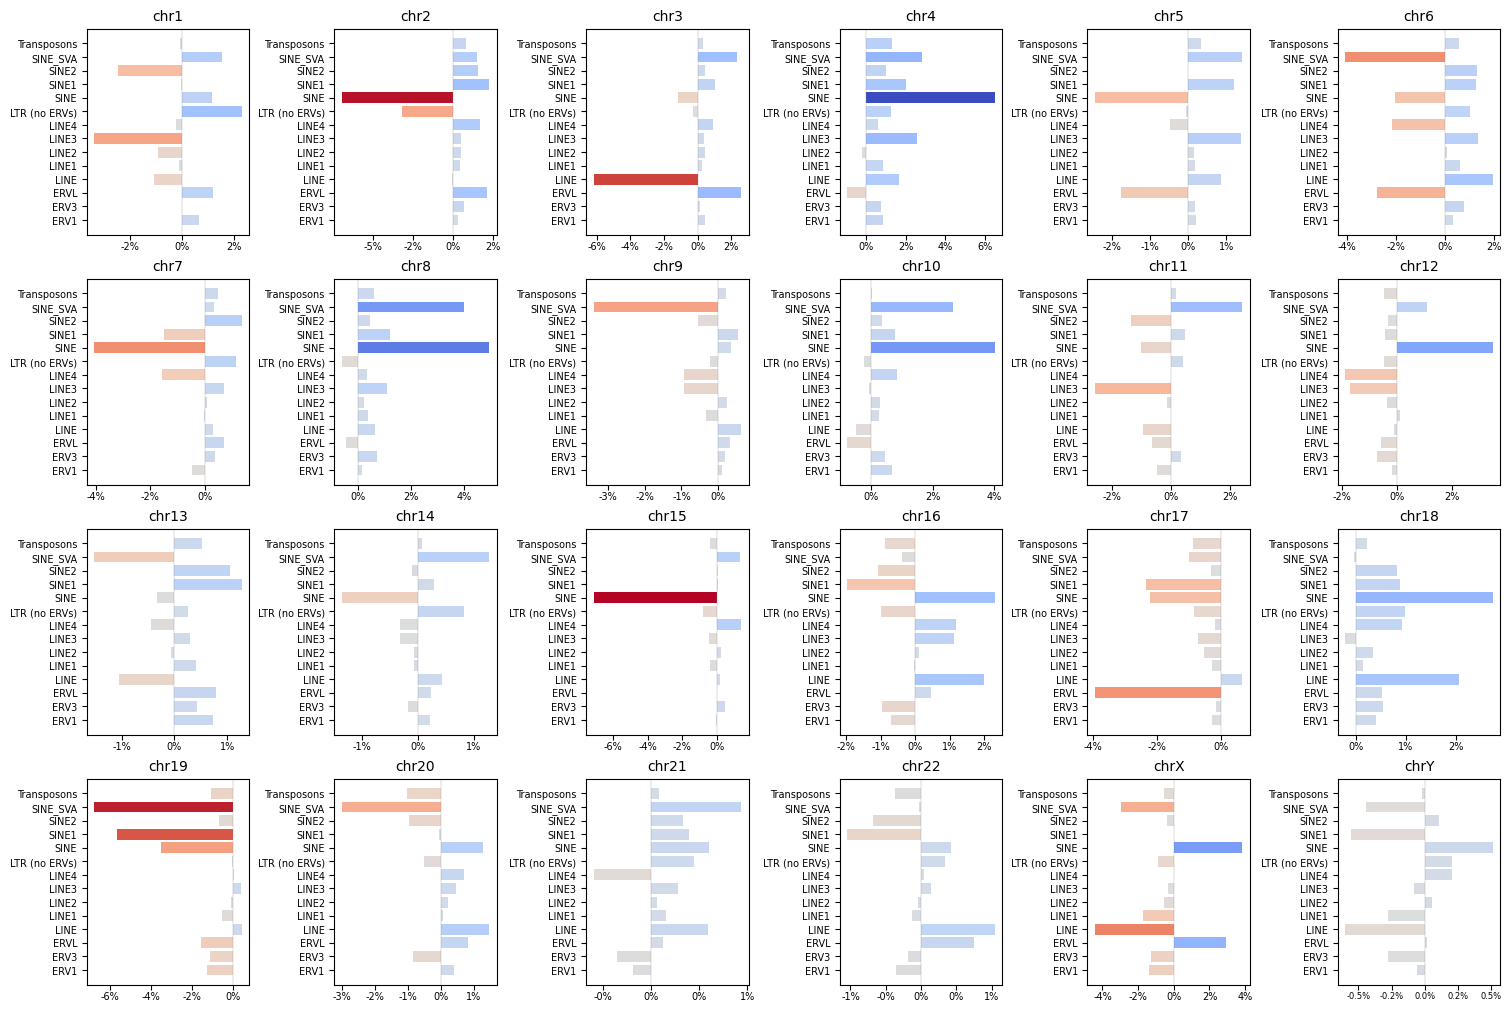

In [26]:
# Convert the DataFrame to long-form
df_long_new = diff.reset_index().melt(id_vars='Superfamily', var_name='Chromosome', value_name='Counts')

# Define a function to map the values to colors
def value_to_color(val):
    norm = mcolors.Normalize(vmin=df_long_new['Counts'].min(), vmax=df_long_new['Counts'].max())
    cmap = plt.get_cmap('coolwarm_r')
    return cmap(norm(val))

# Create a 4x6 grid of subplots
fig, axs = plt.subplots(4, 6, figsize=(15, 10), constrained_layout=True)

# Iterate over each chromosome and plot on separate ax
for ax, chromosome in zip(axs.ravel(), ca.info.CHROMOSOMES['names']):
    subset = df_long_new[df_long_new['Chromosome'] == chromosome]
    for category in subset['Superfamily'].unique():
        subsubset = subset[subset['Superfamily'] == category]
        ax.barh(subsubset['Superfamily'], subsubset['Counts'], color=subsubset['Counts'].apply(value_to_color))
    # Set title for each ax and adjust y-axis labels
    if chromosome=='chrY':
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.1f}%'.format(x)))
        ax.tick_params(axis='x', labelsize=6, which='both', pad=1)
    else:
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}%'.format(x)))
        ax.tick_params(axis='x', labelsize=7, which='both', pad=1)
    ax.set_title(chromosome, fontsize=10)
    ax.set_yticks(subset['Superfamily'].unique())
    ax.set_yticklabels(subset['Superfamily'].unique(), fontsize=7)
    ax.grid(False)
    ax.axvline(0, color='grey', linewidth=0.2)  # Add zero line
# Set a global title for the entire figure
# fig.suptitle('Grouped Horizontal Bar Plot with Diverging Color Palette per Chromosome', fontsize=16)
plt.show()
fig.savefig('figure1-B.png')

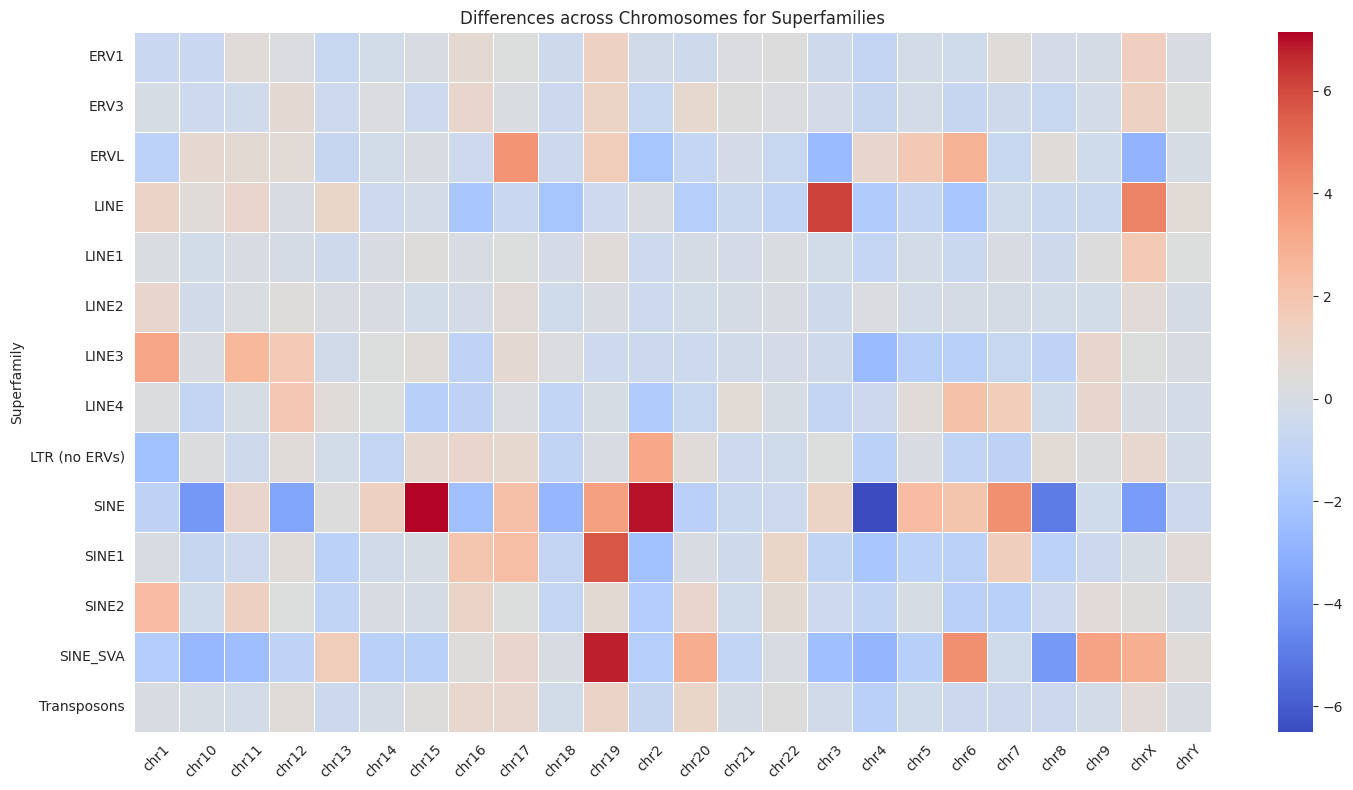

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

# Remove the index column
# diff.drop(columns=["Unnamed: 0"], inplace=True)

# Set the Superfamily as index for the heatmap
df_heatmap = diff.set_index('Superfamily')

# Draw the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(df_heatmap, cmap="coolwarm", annot=False, fmt=".2f", linewidths=.5)
plt.title("Differences across Chromosomes for Superfamilies")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [120]:
cols_with_te_elements = [col for col in te_df.columns if 'TE_Clusters' in col]
for col in cols_with_te_elements:
    te_df[col] = te_df[col] / te_df['n_clusters']

In [187]:
te_df.fillna(0, inplace=True)

In [9]:
te_df
te_df['overlapping_genes']= None
te_df['nearest_gene_before'] = None
te_df['nearest_gene_after'] = None

In [43]:
means = te_df.groupby(by='Superfamily').mean('n_clusters').drop(['COTE'], axis=1)

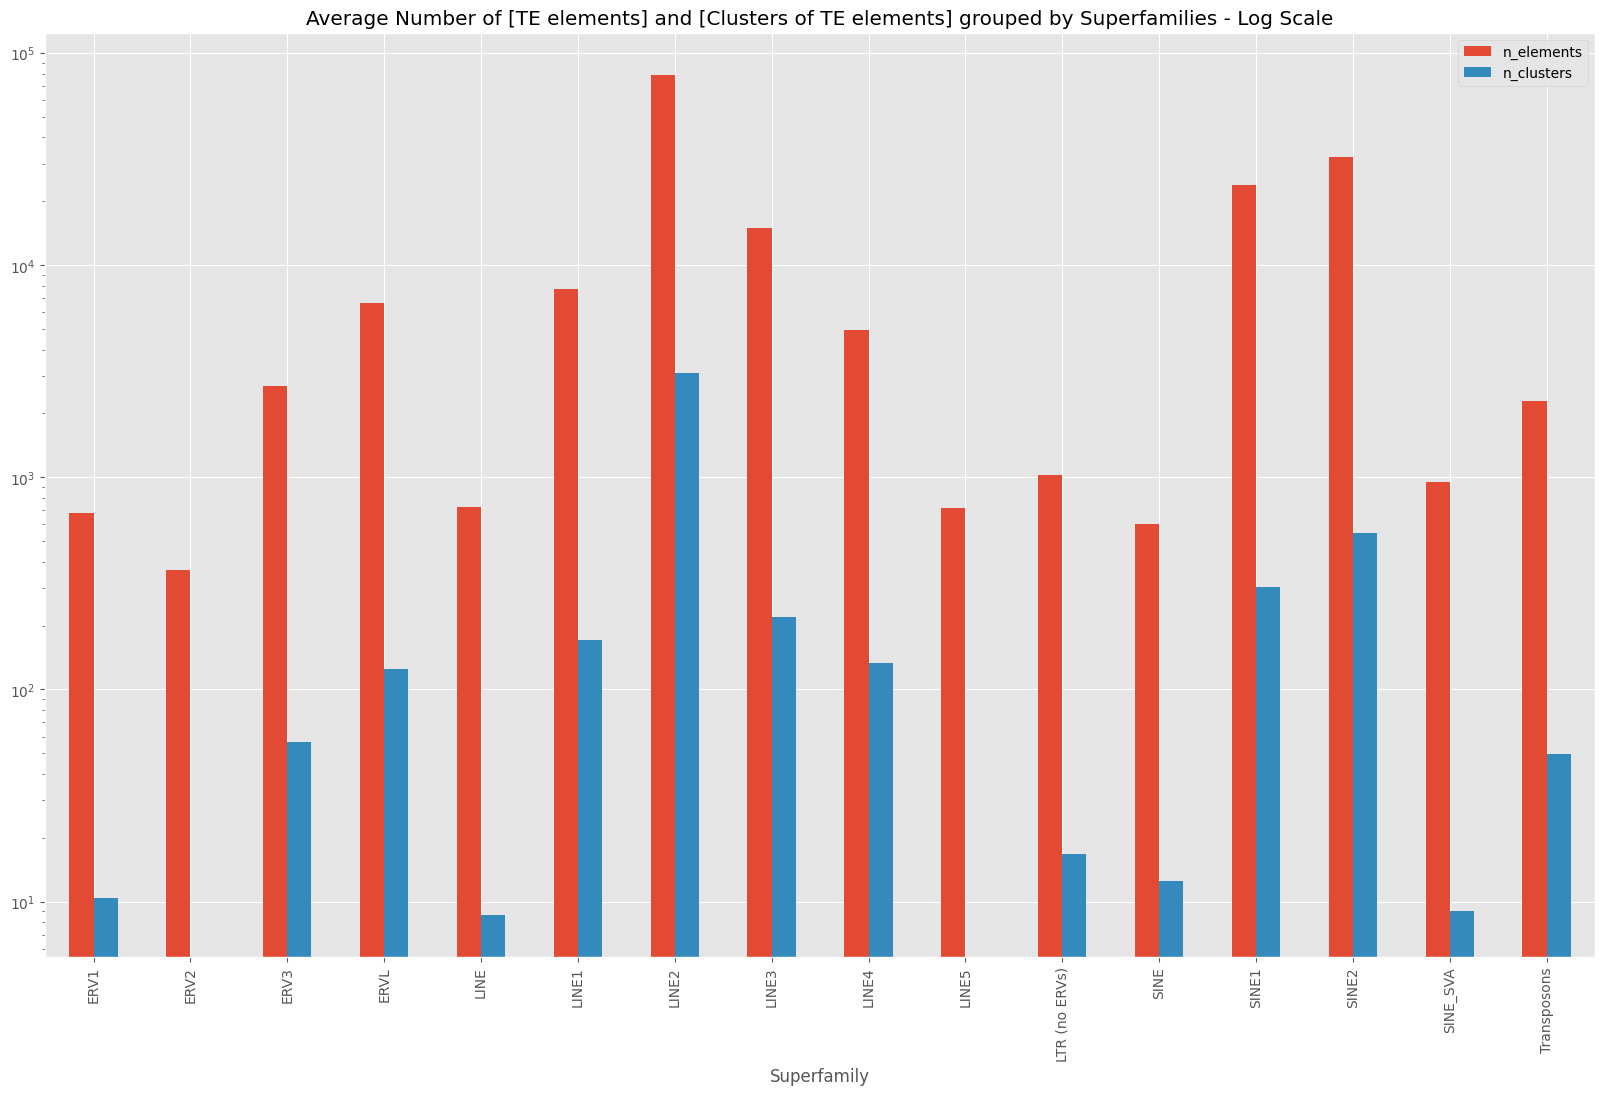

In [28]:
fig, axs = plt.subplots(figsize=(20, 12))
means.plot(kind='bar', logy=True, ax=axs)
plt.title('Average Number of [TE elements] and [Clusters of TE elements] grouped by Superfamilies - Log Scale')
fig.savefig('./mean_n_elements.png',  bbox_inches='tight')

In [166]:
cotes, cotes_names = ca.tl.load_beds(cotes_dir)
cotes = ca.al.chrom_counter(cotes)
cotes.columns = cotes_names
tes, tes_names = ca.tl.load_beds(tes_dir)
tes = ca.al.chrom_counter(tes)
tes.columns = tes_names

In [167]:
# CREAM cannot extract cores for the TEs that have less than 1000 elements, then we don't have clusters for all TEs
# So we should filter out common TEs between chromosomes dataframe and clusters dataframe
short_chromosomes = tes.loc[:, [l not in cotes.columns for l in tes.columns]]
tes = tes.loc[:, [l in cotes.columns for l in tes.columns]]
tes

,691_LTR16A1,1127_MER96B,979_MER3,501_HSMAR2,532_L1M4a2,1202_MLT2C2,526_L1M3c,533_L1M4b,875_LTR8B,988_MER44B,...,625_L1PA4,1184_MLT1J2,550_L1MA7,894_MamGypLTR3a,120_AluYh3,617_L1PA13,567_L1MC5,85_Alu,1383_Tigger18a,1114_MER90a
chr,,,,,,,,,,,,,,,,,,,,,
1,150,124.0,821,133,172,96,52,210,117,172,...,826,549,565,99,229,521,889,351,84,75
2,147,108.0,873,138,148,91,61,455,133,176,...,924,545,599,122,211,634,1347,326,94,98
3,359,0.0,928,99,122,88,40,303,87,134,...,842,474,484,87,182,559,1150,245,121,76
4,167,0.0,550,118,105,113,90,218,93,177,...,911,494,577,79,165,763,769,205,67,76
5,155,0.0,574,147,108,106,73,279,93,140,...,866,406,521,55,157,634,903,215,124,82
6,112,0.0,572,111,133,74,65,159,92,132,...,747,362,557,75,136,536,943,185,56,67
7,102,0.0,571,81,108,62,48,260,120,117,...,567,294,517,52,132,424,880,294,64,57
8,139,0.0,461,125,98,68,61,216,81,133,...,634,377,502,106,118,427,626,190,64,62
9,68,0.0,445,42,75,41,51,195,78,95,...,450,281,341,84,114,307,730,181,46,50


#### Percentile the Numbers

In [168]:
tes = ca.pp.scaler(tes)
cotes = ca.pp.scaler(cotes)

## Differential Analysis of TEs counts of the Clusters VS TEs counts of Chromosomes

### Significant Changes

In [254]:
diff = cotes.loc[:, tes.columns]-tes

AttributeError: 'tuple' object has no attribute 'columns'

In [191]:
diff

,691_LTR16A1,1127_MER96B,979_MER3,501_HSMAR2,532_L1M4a2,1202_MLT2C2,526_L1M3c,533_L1M4b,875_LTR8B,988_MER44B,...,625_L1PA4,1184_MLT1J2,550_L1MA7,894_MamGypLTR3a,120_AluYh3,617_L1PA13,567_L1MC5,85_Alu,1383_Tigger18a,1114_MER90a
chr,,,,,,,,,,,,,,,,,,,,,
1,-0.454229,-11.764706,1.292847,-0.780142,4.759457,-4.041415,1.578604,-0.092464,-3.390931,4.653511,...,-1.319511,1.075047,-1.238181,-7.752545,-3.288000,0.550605,-0.919514,-2.350240,1.388108,-2.520363
2,-5.470785,-1.913346,-2.185133,-7.726764,-4.594984,-0.437108,-5.968689,3.767915,1.491422,-3.470088,...,-1.015558,-4.163247,-2.550020,-0.664752,-0.861470,-1.374430,-1.959721,2.711679,0.588108,-4.429076
3,14.844503,0.000000,-0.135626,-2.209780,-5.957031,3.015799,-3.913894,0.138696,-1.515931,0.081667,...,-1.832073,-0.454223,-0.278693,-0.146176,1.975813,0.120205,-0.666136,-3.314671,6.536216,-2.603350
4,-3.651007,0.000000,-1.727155,3.393057,-5.126953,-2.102513,-8.806262,-0.277393,-1.890931,1.245044,...,-0.528347,-2.077323,-0.016691,-1.741930,-2.652542,1.035444,-0.459413,-3.530207,-2.657297,-6.307054
5,-3.204413,0.000000,-1.524355,-4.897350,-0.010280,4.879002,-7.142857,-4.068423,0.069853,2.975634,...,0.229272,-2.088001,1.555749,-2.084747,-2.353812,-1.374430,-0.027837,-2.633626,3.593514,-3.101276
6,-4.168217,0.000000,-1.505643,3.784994,-1.230983,-5.601817,-6.360078,-3.675451,-5.750000,-2.999391,...,-1.784019,-1.431088,0.220219,-1.428696,-1.569645,-0.909612,1.020981,0.294609,-4.480000,-1.856462
7,-3.796055,0.000000,-0.641585,-1.201941,-0.010280,4.984005,1.969993,-6.010171,0.343137,-5.472404,...,-1.772411,-3.064867,0.694041,-1.849822,0.334106,-3.512033,0.451059,3.438126,-2.417297,-4.730290
8,-2.608953,0.000000,-2.176496,3.001120,-4.785156,-1.921809,0.697978,-0.231160,-1.140931,4.890344,...,0.680291,-1.655036,-0.037367,9.477073,-0.897501,-1.610528,-2.143365,-3.189685,0.285405,-5.145228
9,0.033399,0.000000,-0.744744,-2.351624,-1.030530,-3.103709,1.676451,0.254276,1.007353,-1.268802,...,-1.161093,1.764983,0.051582,4.533194,-0.748136,-0.251371,2.091760,-1.861776,-0.977297,3.258030


In [192]:
outliers = ca.al.identify_outliers({'data':diff.values})

In [193]:
tests = outliers['total']
mask = np.ones_like(tests)
mask[diff<0]= -1
outliers_df = pd.DataFrame((mask*tests).astype(int), columns=tes.columns)

In [222]:
te_meta = pd.read_csv('./analysis/data/repeat_metadata.onlyTEs_full.tsv', sep='\t')
te_df = te_meta.iloc[np.concatenate([np.where(te_meta['repname_numbered'].apply(lambda x: i.split('_')[1]==x.split('_')[0]))[0] for i in TEs]), :].loc[:, ['repname', 'Superfamily', 'repname_numbered']].copy()

In [223]:
outliers_scores = pd.DataFrame([outliers_df.idxmax(), outliers_df.max()], index=['chr', 'score']).T
outliers_scores['chr'] += 1
outliers_scores['chr'] = 'chr'+outliers_scores['chr'].astype('str')
outliers_scores['chr'] = outliers_scores['chr'].astype('category')

In [218]:
passed_outliers = outliers_scores[outliers_scores['score']>=3]

In [228]:
outliers_scores.index = outliers_scores.index.map(lambda x: x.split('_')[-1])

In [229]:
outliers_scores = outliers_scores.merge(te_df, left_index=True, right_on='repname')

In [230]:
passed_outliers = outliers_scores[outliers_scores['score']>=3]

In [231]:
outliers_scores

,chr,score,repname,Superfamily,repname_numbered
352,chr3,5,LTR16A1,ERV3,691_LTR16A1
783,chr19,5,MER96B,Transposons,1127_MER96B
616,chr16,1,MER3,Transposons,979_MER3
164,chr23,4,HSMAR2,Transposons,501_HSMAR2
194,chr23,4,L1M4a2,LINE1,532_L1M4a2
...,...,...,...,...,...
278,chr23,4,L1PA13,LINE1,617_L1PA13
227,chr6,1,L1MC5,LINE1,567_L1MC5
2,chr19,3,Alu,SINE1,85_Alu
923,chr3,3,Tigger18a,Transposons,1383_Tigger18a


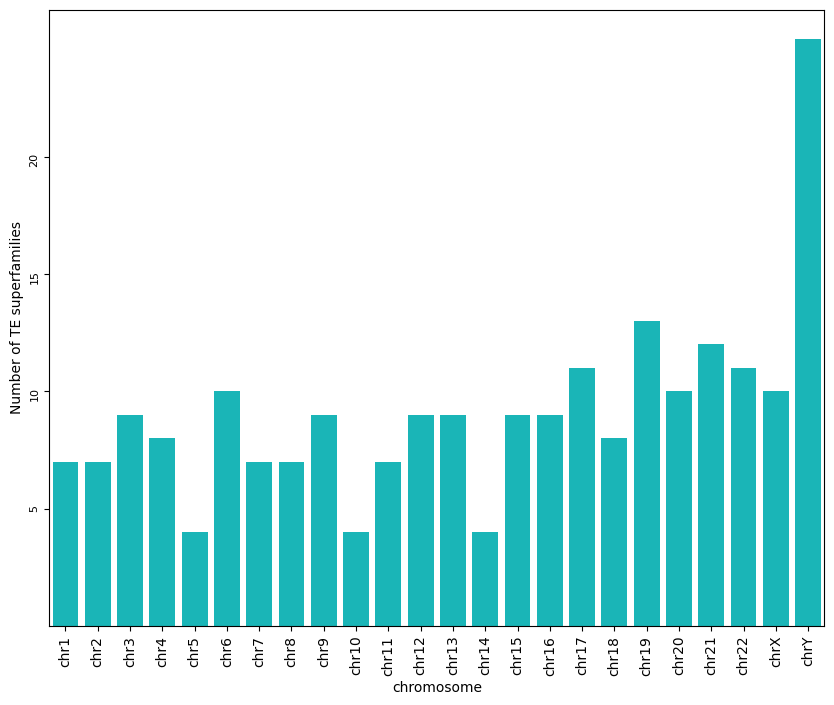

In [232]:
df = passed_outliers['chr'].value_counts(sort=False).reindex(ca.info.CHROMOSOMES['names'][:22]+['chr23', 'chr24'])
df.index = ca.info.CHROMOSOMES['names']
fig = plt.figure(figsize=(10, 8))
sns.barplot(x=df.index, y=df.values, color='darkturquoise')
plt.xticks(rotation=90)
plt.yticks([5, 10, 15, 20], fontsize=8, rotation=90)
plt.ylabel('Number of TE superfamilies')
plt.xlabel('chromosome')
fig.savefig('/Users/mossishahi/Code/lupien/IntData/analysis/figures/figure 1/skew.png', dpi=600, bbox_inches='tight')
plt.show()

In [235]:
outliers_scores

,chr,score,repname,Superfamily,repname_numbered
352,chr3,5,LTR16A1,ERV3,691_LTR16A1
783,chr19,5,MER96B,Transposons,1127_MER96B
616,chr16,1,MER3,Transposons,979_MER3
164,chr23,4,HSMAR2,Transposons,501_HSMAR2
194,chr23,4,L1M4a2,LINE1,532_L1M4a2
...,...,...,...,...,...
278,chr23,4,L1PA13,LINE1,617_L1PA13
227,chr6,1,L1MC5,LINE1,567_L1MC5
2,chr19,3,Alu,SINE1,85_Alu
923,chr3,3,Tigger18a,Transposons,1383_Tigger18a


In [236]:
outliers_scores[outliers_scores['chr']=='chr24']

,chr,score,repname,Superfamily,repname_numbered
679,chr24,4,MER52A,ERV1,1023_MER52A
637,chr24,3,MER41A,ERV1,980_MER41A
266,chr24,4,L1P1,LINE1,605_L1P1
635,chr24,3,MER4-int,ERV1,1013_MER4-int
290,chr24,3,L1PA8,LINE1,630_L1PA8
178,chr24,4,L1M1,LINE1,517_L1M1
929,chr24,4,Tigger2a,Transposons,1389_Tigger2a
176,chr24,4,L1HS,LINE1,516_L1HS
706,chr24,5,MER61-int,ERV1,1056_MER61-int
606,chr24,4,MER1A,Transposons,951_MER1A


In [238]:
outliers_scores[outliers_scores['chr']=='chr23']

,chr,score,repname,Superfamily,repname_numbered
164,chr23,4,HSMAR2,Transposons,501_HSMAR2
194,chr23,4,L1M4a2,LINE1,532_L1M4a2
204,chr23,4,L1MA2,LINE1,543_L1MA2
280,chr23,4,L1PA15,LINE1,620_L1PA15
234,chr23,2,L1MD2,LINE1,573_L1MD2
275,chr23,2,L1PA10,LINE1,614_L1PA10
205,chr23,2,L1MA3,LINE1,544_L1MA3
307,chr23,3,L3,LINE3,648_L3
202,chr23,5,L1MA1,LINE1,542_L1MA1
289,chr23,2,L1PA7,LINE1,628_L1PA7


In [240]:
os.chdir(tes_dir)

In [243]:
os.getcwd()

'/Users/mossishahi/Code/lupien/IntData/data/V2-TEs/TEs'

In [248]:
tes = ca.tl.load_beds('/Users/mossishahi/Code/lupien/IntData/data/V2-TEs/TEs')